In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import dask

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

from myfunc import mysom, mytrack, myfunc
import os
%config InlineBackend.figure_format='retina'

In [3]:
# Parameters
projectdir = '/rcfs/projects/windpower_wfip2uq/liuy351/Tracer'
met_extent    = [-120, -70, 15, 50]
track_extent  = [-97, -93, 28, 32]
som_extent    = [-105, -90, 26, 37]
pcptypes  = ["Total", "MCS", "IDC", "TC", "NC"]

figdir = './som_fig'
os.makedirs(figdir, exist_ok=True)

# Controlling variables
flag_mkdata=True
year1 = 2004
year2 = 2017

In [4]:
mapsize = (2,2)
factor  =('u','v','q')

In [11]:
Count = {}
for season in ['MAM', 'JJA', 'SON', 'DJF']:
    for pcptype in ['mcs', 'idc']:
        outname = mytrack.create_outname(f"{pcptype}_location", (year1,year2))
        tracks  = mytrack.load_data_idc(outname, (year1,year2), season)#, extent=track_extent)
        
        fname_bmu = mysom.bmu_filename(mapsize, factor, season, pcptype)
        bmu  = mysom.read_bmu(fname_bmu, season, pcptype=pcptype, flag_swap=True, flag_cluster=False)
        track_clusters = mysom.calc_cluster_track_mapsize(tracks, bmu, mapsize=mapsize)
        
        for isom, itrack in enumerate(track_clusters):
            # print(itrack)
            track_count = itrack.groupby(itrack['time.month']).count()
            Count[f'{season}_{pcptype}_{isom}'] = track_count



MAM
swaping bmu....
MAM
swaping bmu....
JJA
swaping bmu....
JJA
swaping bmu....
SON
swaping bmu....
SON
swaping bmu....
DJF
swaping bmu....
DJF
swaping bmu....


In [133]:
tracks

<xarray.DataArray 'tracks' (tracks: 2249)>
array([200400034, 200400130, 200400181, ..., 201748023, 201748036, 201748041])
Coordinates:
  * tracks     (tracks) int64 200400034 200400130 ... 201748036 201748041
    lat        (tracks) float32 ...
    lon        (tracks) float32 ...
    time       (tracks) datetime64[ns] 2004-01-03T03:00:00 ... 2017-12-23T06:...
    lifetime   (tracks) float32 ...
    ccrate     (tracks) float32 ...
    sfrate     (tracks) float32 ...
    ccvolrate  (tracks) float32 ...
    sfvolrate  (tracks) float32 ...
    distance   (tracks) float32 ...
    direction  (tracks) float32 ...

In [61]:
count = []
for pcptype in ['mcs', 'idc']:
    _count = []
    for isom in np.arange(4):
        _count.append(xr.concat(
            [Count[f'MAM_{pcptype}_{isom}'], 
             Count[f'JJA_{pcptype}_{isom}'], 
             Count[f'SON_{pcptype}_{isom}'], 
             Count[f'DJF_{pcptype}_{isom}']], 
            dim='month')
        )
    count.append(xr.concat(_count, dim='som'))
count = xr.concat(count, dim='pcptype')
count.coords['som'] = np.arange(4)
count.coords['pcptype'] = ['mcs', 'idc']

In [62]:
count = count.roll(month=1)
count.coords['month'] = count.coords['month'].roll(month=1) 

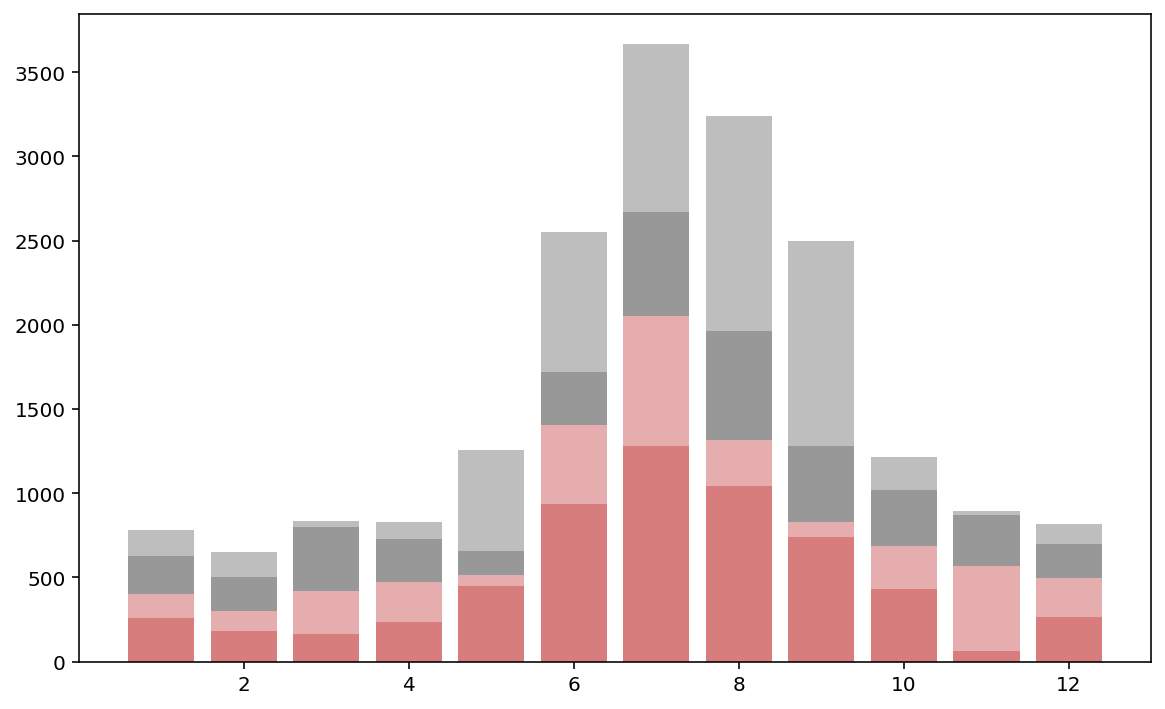

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True, sharey=True)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.4, wspace=0.05)

bottom = np.zeros(12)
x = count.month.data
# color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
color = ['indianred', 'indianred', 'tab:gray', 'tab:gray']
alpha = [0.8, 0.5, 0.8, 0.5]
for i in np.arange(4):  
    y = count.sel(pcptype='idc', som=i).data
    # y = y / count.sel(pcptype='idc').sum('som').data
    ax.bar(x, y, bottom=bottom, alpha=alpha[i], color=color[i])
    bottom += y

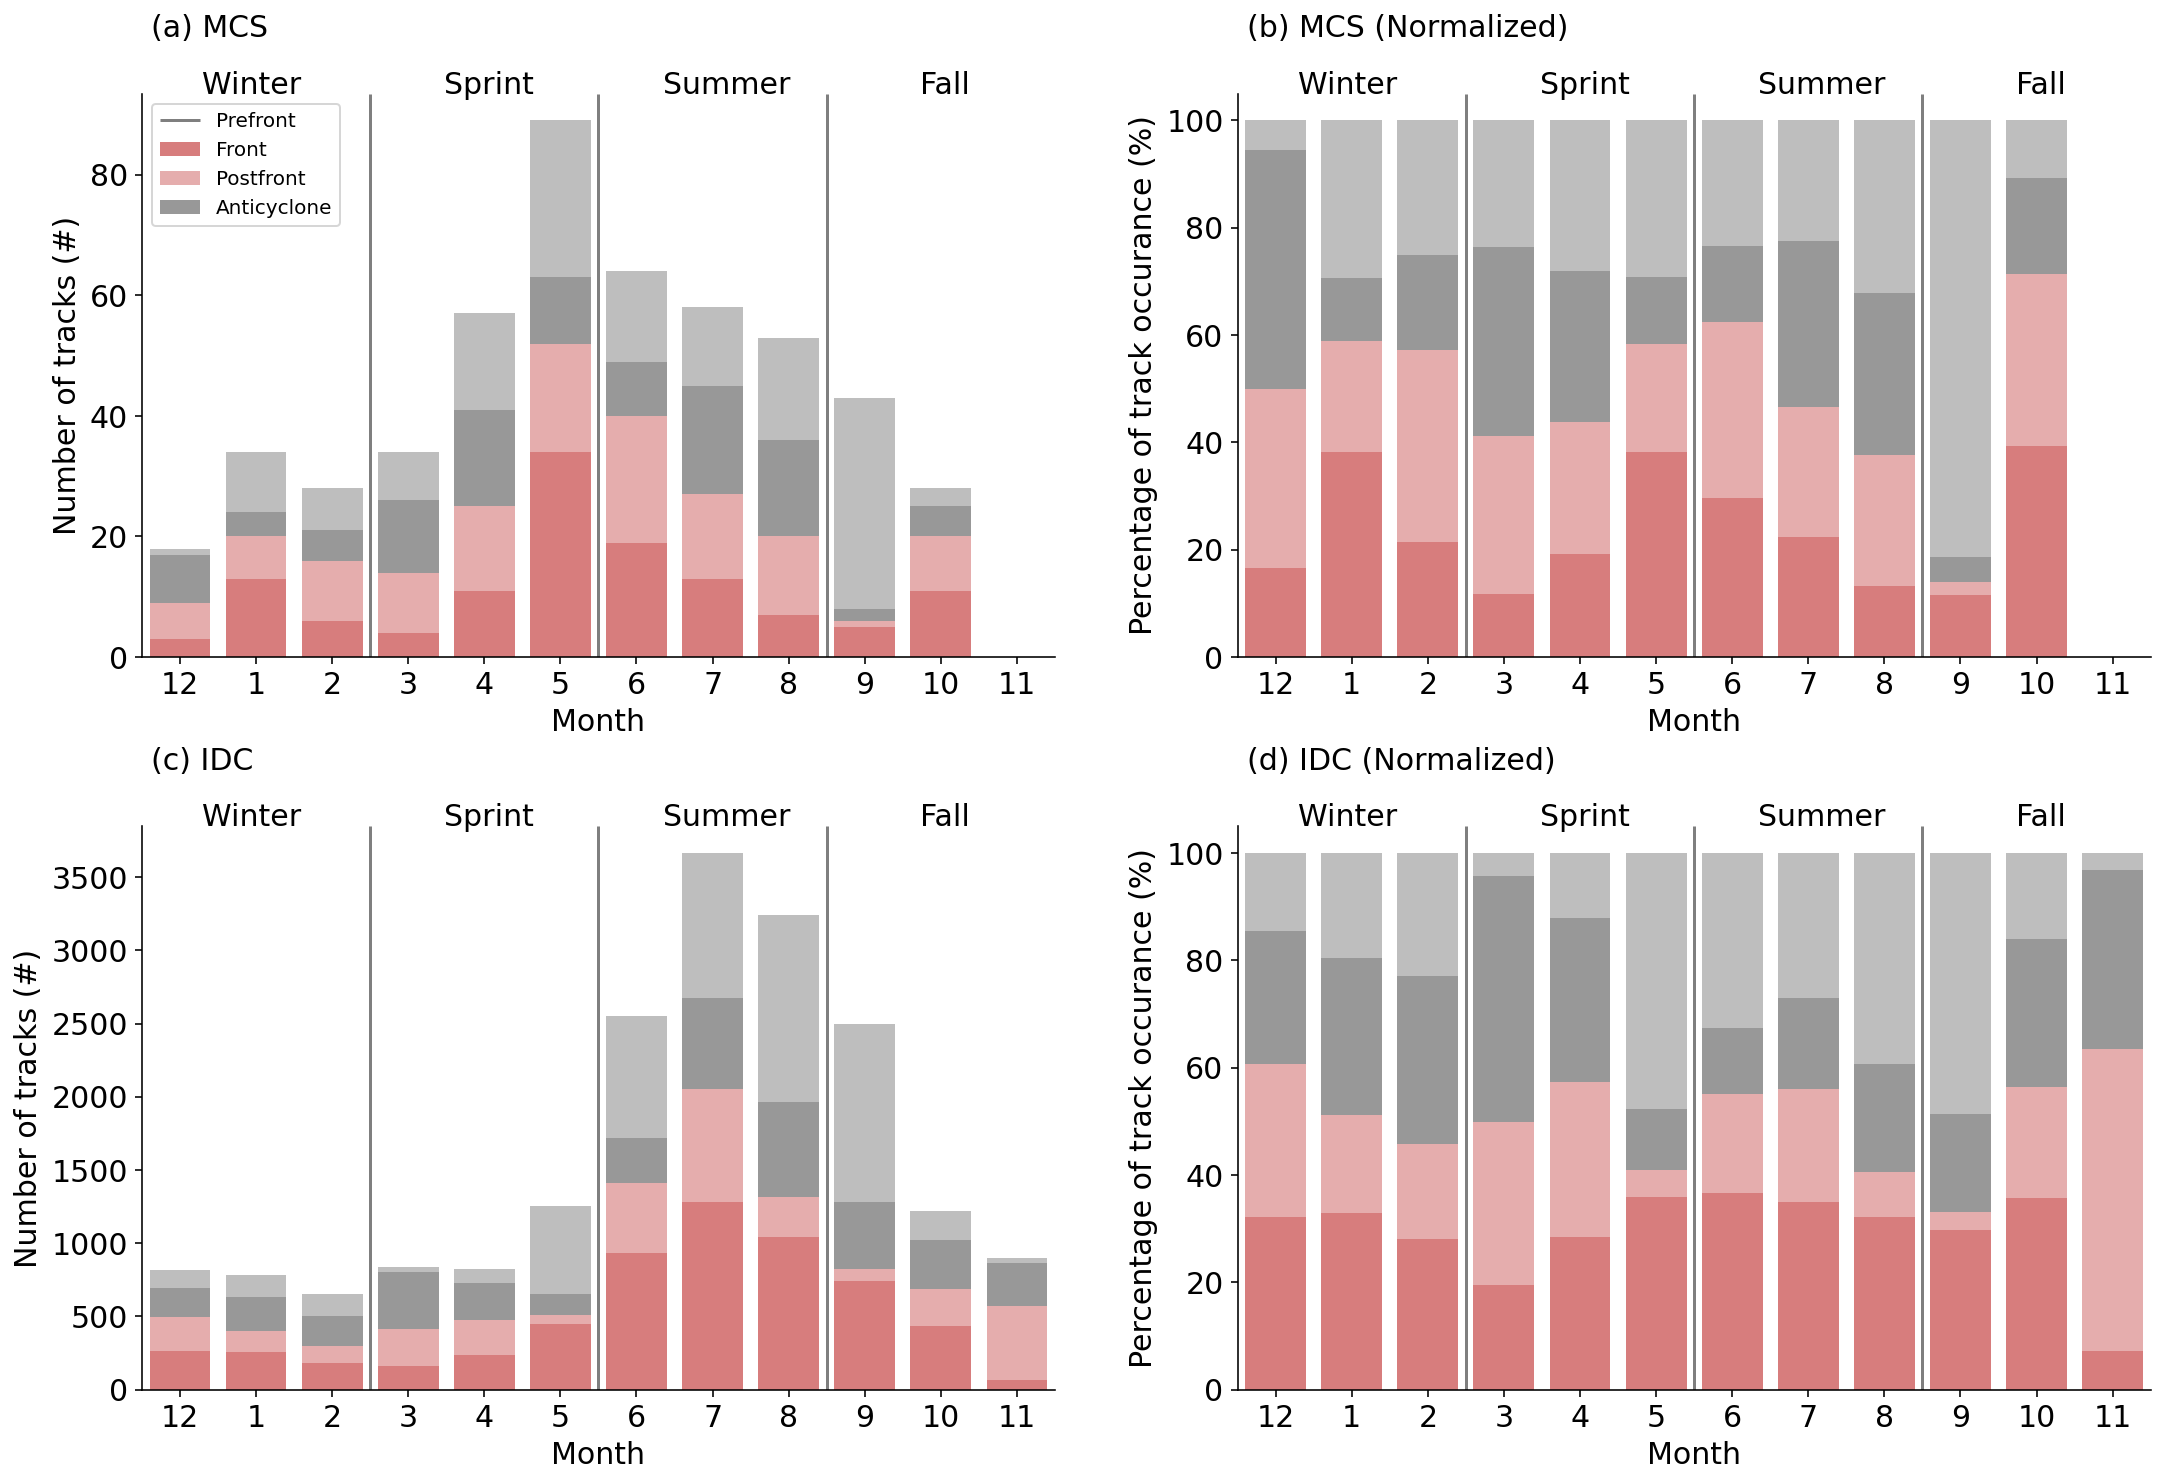

In [132]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'  

def plot_barchart(ax, count, pcp, flag_norm=False):
    bottom = np.zeros(12)
    x = np.arange(12)
    # color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
    color = ['indianred', 'indianred', 'tab:gray', 'tab:gray']
    alpha = [0.8, 0.5, 0.8, 0.5]
    for i in np.arange(4):  
        y = count.sel(pcptype=pcp, som=i).data
        if flag_norm: y = y / count.sel(pcptype=pcp).sum('som').data * 100.
        ax.bar(x, y, bottom=bottom, alpha=alpha[i], color=color[i])
        bottom += y
    ax.set_xlabel('Month')
    if flag_norm:
        ax.set_ylabel('Percentage of track occurance (%)')
    else:
        ax.set_ylabel('Number of tracks (#)')
    ax.set_xticks(np.arange(0, 12))
    ax.set_xticklabels([12]+list(np.arange(1, 12)))
    ax.spines[['right', 'top']].set_visible(False)
    ylim = ax.get_ylim()
    ax.vlines([2.5, 5.5, 8.5], *ylim, color='tab:gray')
    ax.set_ylim(ylim)
    ax.set_xlim(-0.5, 11.5)
    ax.text(0.12, 1.0, 'Winter', transform=ax.transAxes, ha='center')
    ax.text(0.38, 1.0, 'Sprint', transform=ax.transAxes, ha='center')
    ax.text(0.64, 1.0, 'Summer', transform=ax.transAxes, ha='center')
    ax.text(0.88, 1.0, 'Fall', transform=ax.transAxes, ha='center')
    
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=False, sharey=False)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.3, wspace=0.2)
axs = axs.ravel()
plot_barchart(axs[0], count, 'mcs', flag_norm=False)
plot_barchart(axs[1], count, 'mcs', flag_norm=True)
plot_barchart(axs[2], count, 'idc', flag_norm=False)
plot_barchart(axs[3], count, 'idc', flag_norm=True)

axs[0].text(0.01, 1.1, f'(a) MCS', transform=axs[0].transAxes)
axs[1].text(0.01, 1.1, f'(b) MCS (Normalized)', transform=axs[1].transAxes)
axs[2].text(0.01, 1.1, f'(c) IDC', transform=axs[2].transAxes)
axs[3].text(0.01, 1.1, f'(d) IDC (Normalized)', transform=axs[3].transAxes)
axs[0].legend(['Prefront', 'Front', 'Postfront', 'Anticyclone'], fontsize=10)

print()

In [171]:
Mean = {}
rr = track_extent
for season in ['MAM', 'JJA', 'SON', 'DJF']:
    for pcptype in ['mcs', 'idc']:
        outname = mytrack.create_outname(f"{pcptype}_location", (year1,year2))
        tracks  = mytrack.load_data_idc(outname, (year1,year2), season)#, extent=track_extent)
        
        fname_bmu = mysom.bmu_filename(mapsize, factor, season, pcptype)
        bmu  = mysom.read_bmu(fname_bmu, season, pcptype=pcptype, flag_swap=True, flag_cluster=False)
        track_clusters = mysom.calc_cluster_track_mapsize(tracks, bmu, mapsize=mapsize)
        
        for isom, itrack in enumerate(track_clusters):
            # print(itrack)
            pcprate = (itrack['ccrate'] + itrack['sfrate']) * itrack['lifetime']
            # ind = (pcprate['lat']>rr[2]) & (pcprate['lat']>rr[3]) & (pcprate['lon']>rr[0]) & (pcprate['lon']<rr[1])
            # pcprate = pcprate.sel(tracks=ind)
            track_count = pcprate.groupby(pcprate['time.month']).mean('tracks')
            Mean[f'{season}_{pcptype}_{isom}'] = track_count

MAM
swaping bmu....
MAM
swaping bmu....
JJA
swaping bmu....
JJA
swaping bmu....
SON
swaping bmu....
SON
swaping bmu....
DJF
swaping bmu....
DJF
swaping bmu....


In [166]:
pcprate

<xarray.DataArray (tracks: 421)>
array([  7.141863 ,   7.393445 ,   8.748871 ,   5.831818 ,   1.9123465,
        65.369385 ,   2.8124998,  10.544447 ,   8.537373 ,   2.4581945,
         6.4570875,  12.133532 ,   3.52627  ,   4.4544377,   3.1685715,
         5.469974 ,   8.376111 ,  73.718    ,   7.641506 ,   8.705848 ,
         5.852748 ,   5.320695 ,   6.9859324,   2.8725   ,   7.550357 ,
         3.790276 ,  15.340687 ,  17.352911 ,  14.560385 ,  15.905128 ,
         1.2166667,   5.306923 ,   3.8925002,   6.8155246,   1.880738 ,
         2.8574243,   2.4833333,   3.3426945,  40.078136 ,   1.9244168,
         3.0441203,   4.6007404,   7.1169806,   6.505557 ,  28.106518 ,
         4.8454514,  14.058606 ,  15.498349 ,   1.9000001,  47.674072 ,
         1.9612501,   9.12     ,  13.283587 ,   3.9140835,   4.588368 ,
         2.7895238,  19.762459 ,  10.836985 ,   7.08615  ,   9.7448015,
         9.53479  ,  21.372757 ,   6.376333 , 147.67836  ,  42.75119  ,
         0.655    ,   3.4136362,   8.748091 ,   4.8366666,  66.82671  ,
         2.5273225,   4.4433336,   4.644085 ,   4.2184267,   1.9692731,
         3.4609878,   2.534202 ,   3.3980873,   4.668792 ,   4.207986 ,
         3.1142511,   5.2213335,   2.920639 ,   2.4076424,   6.5425644,
         5.7524495,   9.031287 ,   5.9575768,   5.5444613,   8.242934 ,
         2.8092737,  11.394655 ,   5.8257427,   4.7972245,  33.333244 ,
        12.616442 ,   2.4641113,   1.695    ,   1.8993751,  12.7378025,
...
         3.1725001,   2.2818334,  12.03911  ,   4.801446 ,   8.852334 ,
        14.756107 ,  28.788082 ,   5.5758495,  12.826323 ,  16.682638 ,
         6.5566196,  10.322067 ,  24.751577 ,   9.805299 ,   1.72     ,
         5.7916307,   7.127964 ,   2.4790475,  13.595592 ,  10.445232 ,
         3.9709048,  58.39253  ,  34.98626  ,   4.79373  ,   6.5711017,
         6.6122046,   6.8745747,   2.3572917,   2.6038642,  71.20328  ,
         6.891143 ,   2.9020553,  11.952751 ,   2.6836667,   2.122    ,
        50.954407 ,  14.974583 ,   5.041667 ,   5.3960524,   3.067143 ,
        86.728    ,  23.07475  ,   3.6458664,   3.8995922,   6.0012503,
         5.244981 ,   8.959464 ,   7.732814 ,   6.21702  ,   2.14625  ,
         6.268551 ,  54.28232  ,   3.8075001,  15.429243 ,   6.8034883,
         2.5577013,  18.246532 ,   2.564621 ,  10.907046 ,  39.539837 ,
         3.845818 ,   5.8122864,   4.0818286,   3.236875 ,   2.8899999,
         6.7202992,   8.018095 ,   3.357902 ,   4.9731426,   2.7508483,
         5.9599276,   9.478244 ,   3.0440001,   4.701536 ,   8.924242 ,
        39.046288 ,  15.072199 ,  20.291016 ,  14.622399 ,   4.516462 ,
         2.6645   ,   5.924999 ,   1.8199999,   5.5014277,   7.0634604,
         2.0971298,  13.813044 ,  10.207484 ,   5.5985184,   3.9535425,
        72.593475 ,  38.617317 ,   2.7216668,   5.3957615,   3.8525002,
        16.527512 ], dtype=float32)
Coordinates:
  * tracks     (tracks) int64 200400240 200400272 ... 201747875 201747877
    lat        (tracks) float32 31.53 28.83 30.93 30.28 ... 28.86 29.67 28.91
    lon        (tracks) float32 -95.87 -96.58 -96.73 ... -96.35 -96.85 -96.15
    time       (tracks) datetime64[ns] 2004-01-12T20:00:00 ... 2017-12-17T02:...
    lifetime   (tracks) float32 2.0 2.0 2.0 1.0 1.0 8.0 ... 10.0 1.0 1.0 1.0 1.0
    ccrate     (tracks) float32 1.891 2.205 2.586 4.122 ... 2.523 1.723 9.339
    sfrate     (tracks) float32 1.68 1.492 1.788 1.71 ... 1.573 2.873 2.13 7.188
    ccvolrate  (tracks) float32 71.87 30.9 179.3 90.68 ... 6.89 138.7 6.89 905.9
    sfvolrate  (tracks) float32 43.67 76.26 221.2 20.52 ... 321.8 2.13 920.1
    distance   (tracks) float32 13.13 452.8 19.73 0.0 0.0 ... 0.0 0.0 0.0 0.0
    direction  (tracks) float32 87.36 212.9 9.339 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [163]:
mean = []
for pcptype in ['mcs', 'idc']:
    _mean = []
    for isom in np.arange(4):
        _mean.append(xr.concat(
            [Mean[f'MAM_{pcptype}_{isom}'], 
             Mean[f'JJA_{pcptype}_{isom}'], 
             Mean[f'SON_{pcptype}_{isom}'], 
             Mean[f'DJF_{pcptype}_{isom}']], 
            dim='month')
        )
    mean.append(xr.concat(_mean, dim='som'))
mean = xr.concat(mean, dim='pcptype')
mean.coords['som'] = np.arange(4)
mean.coords['pcptype'] = ['mcs', 'idc']

In [164]:
mean = mean.roll(month=1)
mean.coords['month'] = mean.coords['month'].roll(month=1) 

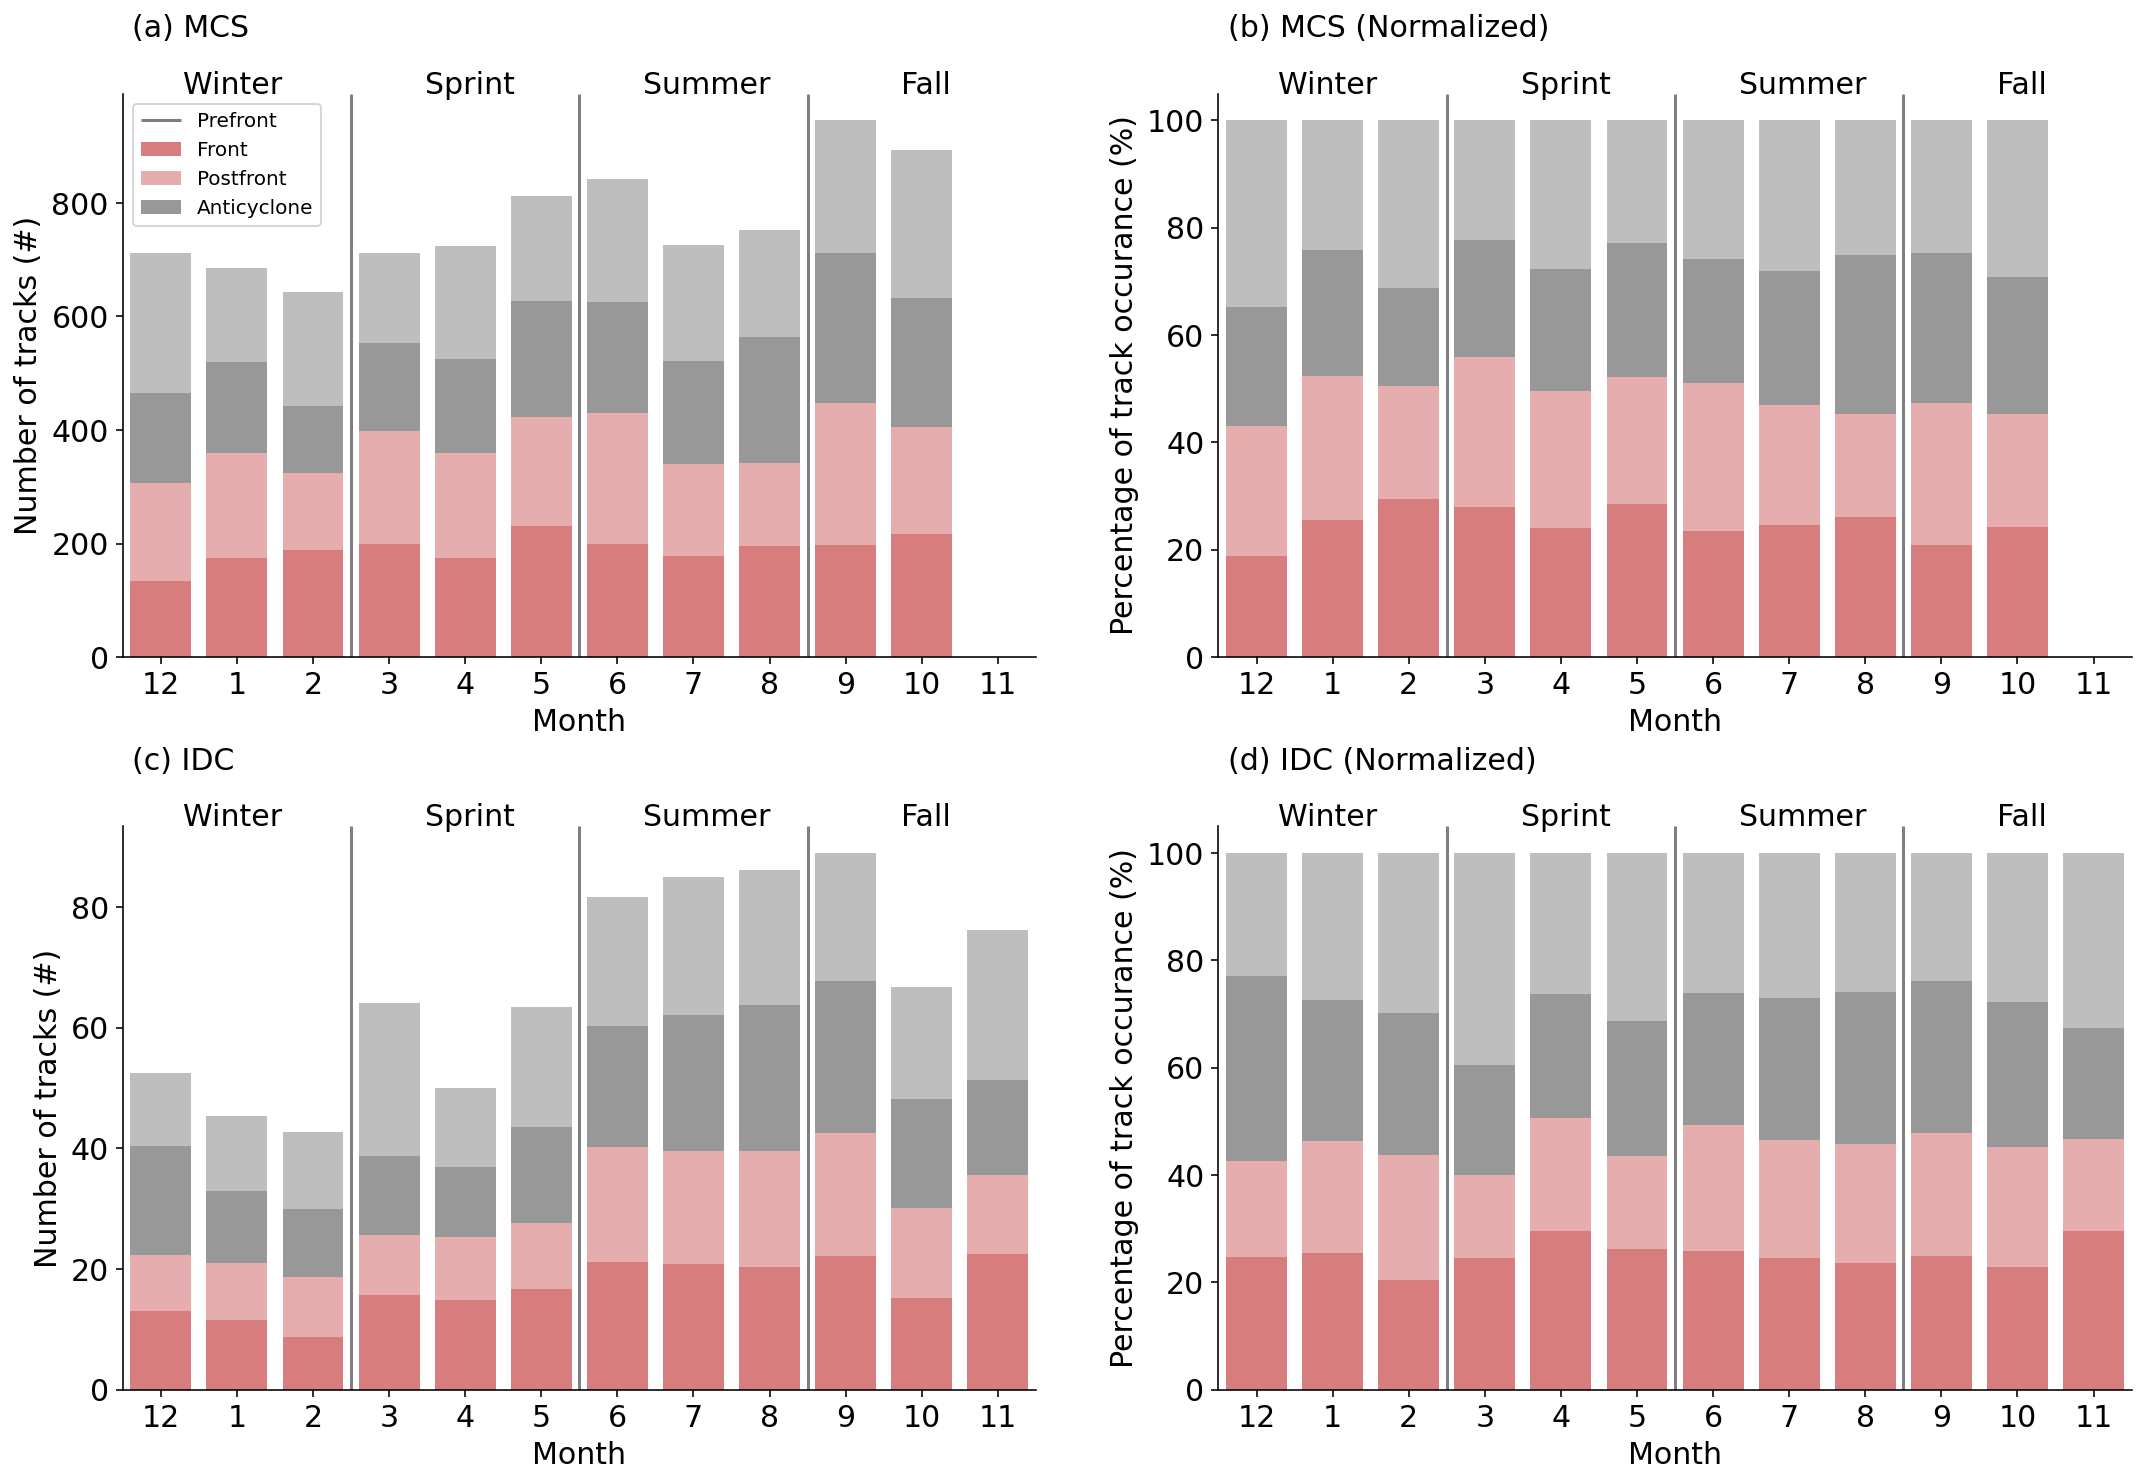

In [165]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'  

def plot_barchart(ax, count, pcp, flag_norm=False):
    bottom = np.zeros(12)
    x = np.arange(12)
    # color = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']
    color = ['indianred', 'indianred', 'tab:gray', 'tab:gray']
    alpha = [0.8, 0.5, 0.8, 0.5]
    for i in np.arange(4):  
        y = count.sel(pcptype=pcp, som=i).data
        if flag_norm: y = y / count.sel(pcptype=pcp).sum('som').data * 100.
        ax.bar(x, y, bottom=bottom, alpha=alpha[i], color=color[i])
        bottom += y
    ax.set_xlabel('Month')
    if flag_norm:
        ax.set_ylabel('Percentage of track occurance (%)')
    else:
        ax.set_ylabel('Number of tracks (#)')
    ax.set_xticks(np.arange(0, 12))
    ax.set_xticklabels([12]+list(np.arange(1, 12)))
    ax.spines[['right', 'top']].set_visible(False)
    ylim = ax.get_ylim()
    ax.vlines([2.5, 5.5, 8.5], *ylim, color='tab:gray')
    ax.set_ylim(ylim)
    ax.set_xlim(-0.5, 11.5)
    ax.text(0.12, 1.0, 'Winter', transform=ax.transAxes, ha='center')
    ax.text(0.38, 1.0, 'Sprint', transform=ax.transAxes, ha='center')
    ax.text(0.64, 1.0, 'Summer', transform=ax.transAxes, ha='center')
    ax.text(0.88, 1.0, 'Fall', transform=ax.transAxes, ha='center')
    
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=False, sharey=False)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.3, wspace=0.2)
axs = axs.ravel()
plot_barchart(axs[0], mean, 'mcs', flag_norm=False)
plot_barchart(axs[1], mean, 'mcs', flag_norm=True)
plot_barchart(axs[2], mean, 'idc', flag_norm=False)
plot_barchart(axs[3], mean, 'idc', flag_norm=True)

axs[0].text(0.01, 1.1, f'(a) MCS', transform=axs[0].transAxes)
axs[1].text(0.01, 1.1, f'(b) MCS (Normalized)', transform=axs[1].transAxes)
axs[2].text(0.01, 1.1, f'(c) IDC', transform=axs[2].transAxes)
axs[3].text(0.01, 1.1, f'(d) IDC (Normalized)', transform=axs[3].transAxes)
axs[0].legend(['Prefront', 'Front', 'Postfront', 'Anticyclone'], fontsize=10)

print()

In [161]:
itrack

<xarray.DataArray 'tracks' (tracks: 421)>
array([200400240, 200400272, 200400716, ..., 201747874, 201747875, 201747877])
Coordinates:
  * tracks     (tracks) int64 200400240 200400272 ... 201747875 201747877
    lat        (tracks) float32 ...
    lon        (tracks) float32 ...
    time       (tracks) datetime64[ns] 2004-01-12T20:00:00 ... 2017-12-17T02:...
    lifetime   (tracks) float32 ...
    ccrate     (tracks) float32 ...
    sfrate     (tracks) float32 ...
    ccvolrate  (tracks) float32 ...
    sfvolrate  (tracks) float32 ...
    distance   (tracks) float32 ...
    direction  (tracks) float32 ...